<a href="https://colab.research.google.com/github/w-oke/covid_reproduction/blob/main/covid_owid_2_analysis_baseline_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The data loaded in this Notebook is based on the output of: covid_owid_1_preparation.ipynb, which can be accessed from:
https://github.com/w-oke/covid_reproduction.

In [1]:
PYTHONHASHSEED=0
import urllib.request
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from tensorflow import keras

In [2]:
df_link = 'https://github.com/w-oke/covid_reproduction/raw/main/covid_owid_df.parquet'
df1 = pd.read_parquet(df_link)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14671 entries, 0 to 14670
Data columns (total 30 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   iso_code                             14671 non-null  object        
 1   location                             14671 non-null  object        
 2   date                                 14671 non-null  datetime64[ns]
 3   reproduction_rate                    14671 non-null  float64       
 4   new_tests_smoothed_per_thousand      14671 non-null  float64       
 5   people_vaccinated_per_hundred        14671 non-null  float64       
 6   people_fully_vaccinated_per_hundred  14671 non-null  float64       
 7   total_boosters_per_hundred           14671 non-null  float64       
 8   stringency_index                     14671 non-null  float64       
 9   population_density                   14671 non-null  float64       
 10  median_age

In [3]:
df1.describe()

,reproduction_rate,new_tests_smoothed_per_thousand,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,stringency_index,population_density,median_age,gdp_per_capita,extreme_poverty,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,Alpha,Beta,Delta,Epsilon,Eta,Gamma,Iota,Kappa,Lambda,Mu,Omicron,non_who,date_diff
count,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000
mean,0.981247,0.024932,0.142838,0.114042,0.021666,0.560950,0.015554,0.473407,0.156399,0.134494,0.681668,0.199699,0.587462,0.590860,0.135999,0.031464,0.278307,0.001583,0.005016,0.021805,0.002054,0.002174,0.006041,0.005961,0.001984,0.510628,0.510624
std,0.309696,0.059803,0.224880,0.209447,0.066831,0.185213,0.078171,0.280223,0.168096,0.241245,0.314402,0.175682,0.230449,0.272662,0.240658,0.101743,0.407454,0.013383,0.031222,0.079873,0.017536,0.019252,0.039937,0.040701,0.019252,0.443168,0.289618
min,-0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.830000,0.002293,0.000000,0.000000,0.000000,0.435200,0.001848,0.208459,0.032584,0.006452,0.443836,0.068613,0.413206,0.355240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026047,0.259259
50%,1.000000,0.009071,0.011376,0.003167,0.000000,0.564800,0.004167,0.468278,0.099553,0.012903,0.858901,0.153285,0.633403,0.632327,0.002397,0.000156,0.000434,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500050,0.518519
75%,1.150000,0.025561,0.214730,0.119361,0.003309,0.703700,0.010465,0.740181,0.228384,0.127742,0.906227,0.270073,0.755602,0.813499,0.177391,0.023175,0.732812,0.000137,0.000303,0.012787,0.000101,0.000042,0.003552,0.001837,0.000000,0.999999,0.765432
max,4.190000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
# import the dictionary var with lists of features:
var_link = 'https://github.com/w-oke/covid_reproduction/raw/main/covid_owid_var_dictionary.pkl'
a_file = "covid_owid_var_dictionary.pkl"
data = urllib.request.urlretrieve(var_link, a_file) # download the file
with open(a_file, 'rb') as f:
        var = pickle.load(f)

print('The keys of the \'var\' dict are: ', var.keys())
print()
var

The keys of the 'var' dict are:  dict_keys(['y', 'meta', 'number', 'variants', 'scale', 'vaccine', 'imputer_no_date', 'imputer_date'])



{'imputer_date': ['new_tests_smoothed_per_thousand',
  'people_vaccinated_per_hundred',
  'people_fully_vaccinated_per_hundred',
  'total_boosters_per_hundred',
  'gdp_per_capita',
  'hospital_beds_per_thousand',
  'stringency_index',
  'date_diff'],
 'imputer_no_date': ['population_density',
  'median_age',
  'gdp_per_capita',
  'extreme_poverty',
  'handwashing_facilities',
  'hospital_beds_per_thousand',
  'life_expectancy',
  'human_development_index'],
 'meta': ['date', 'iso_code', 'location'],
 'number': ['new_tests_smoothed_per_thousand',
  'people_vaccinated_per_hundred',
  'people_fully_vaccinated_per_hundred',
  'total_boosters_per_hundred',
  'stringency_index',
  'population_density',
  'median_age',
  'human_development_index',
  'gdp_per_capita',
  'extreme_poverty',
  'handwashing_facilities',
  'hospital_beds_per_thousand',
  'life_expectancy'],
 'scale': ['new_tests_smoothed_per_thousand',
  'people_vaccinated_per_hundred',
  'people_fully_vaccinated_per_hundred',
  't

## Data Preparation and Visualization Function



In [5]:
# allocate 20% of the data set to testing
X_train, X_test, y_train, y_test = train_test_split(
                        df1[var['number']+var['variants']], df1[var['y']].values, 
                        test_size=0.2, random_state=1)

In [6]:
def visualize_regression_results(df, title):
  dfPd = df.copy()
  dfPd.sort_values("reproduction_rate", ascending=False, inplace=True)

  plt.plot(dfPd.prediction, dfPd.reproduction_rate, 'o', label = 'Observations')
  plt.xlabel('reproduction_rate')
  plt.ylabel('reproduction_rate')

  # Draw estimates
  plt.plot(dfPd.prediction, dfPd.prediction, 'r+', label='Estimates')

  # Plot regression line
  plt.plot(dfPd.prediction, dfPd.prediction, 'r-', label='Regression line')

  # Plot errors
  plt.vlines(dfPd.prediction, dfPd.prediction, dfPd.reproduction_rate, linestyles='dashed', label = 'errors')

  # Add legend
  plt.legend()
  plt.title(title)
  plt.show()

## Linear Regression Model - Baseline

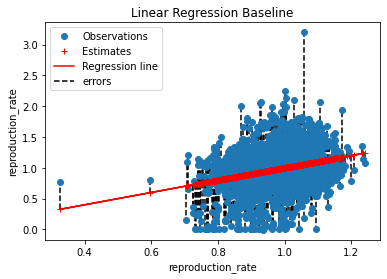



Metrics for Linear Regression Baseline
Explained variance: 0.08
Mean squared error: 0.09


In [12]:
# create a baseline linear regression model to compare other models

from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, mean_squared_error

baseline_model = LinearRegression().fit(X_train, y_train)
predictions = baseline_model.predict(X_test)
predictions = [p[0] for p in predictions]

df_baseline_linear = pd.DataFrame()
df_baseline_linear['prediction'] = predictions
df_baseline_linear['reproduction_rate'] = y_test
df_baseline_linear['residuals'] = df_baseline_linear['prediction'] - df_baseline_linear['reproduction_rate']

visualize_regression_results(df_baseline_linear, "Linear Regression Baseline")

print("\n\nMetrics for Linear Regression Baseline")
print(f"Explained variance: {explained_variance_score(y_test, predictions):.2f}")
print(f"Mean squared error: {mean_squared_error(y_test, predictions):.2f}")

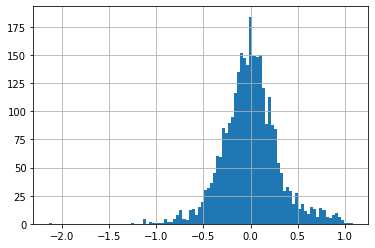

In [13]:
df_baseline_linear['residuals'].hist(bins=100)

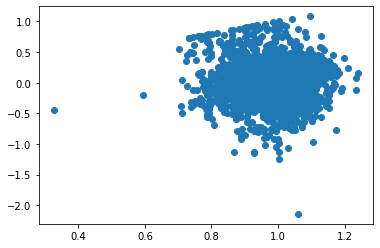

In [14]:
plt.scatter(df_baseline_linear['prediction'], df_baseline_linear['residuals'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


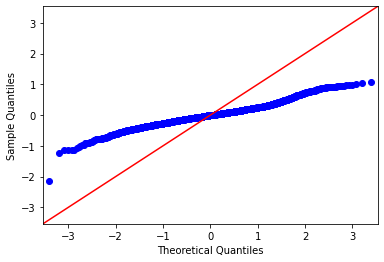

In [15]:
import numpy as np
import statsmodels.api as sm
import pylab

sm.qqplot(df_baseline_linear['residuals'], line='45')
pylab.show()

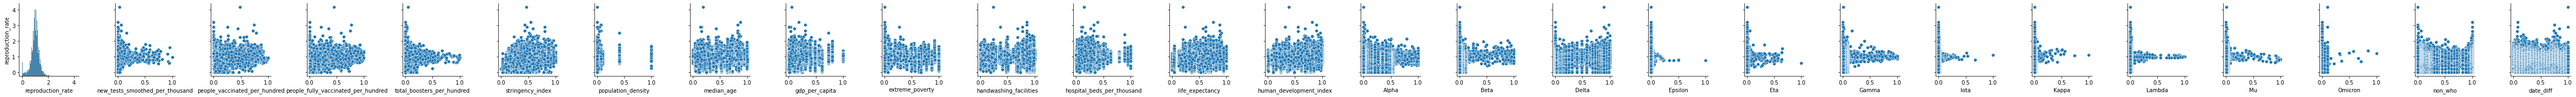

In [25]:
import seaborn as sns

sns.pairplot(df1, y_vars=['reproduction_rate'])

## Random Forest Regression - Advanced Baseline

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


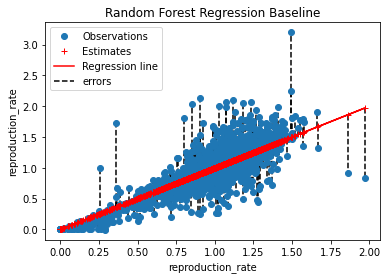



Metrics for Random Forest Regression Baseline
Explained variance: 0.69
Mean squared error: 0.03


In [ ]:
# create a baseline linear regression model to compare other models

from sklearn.ensemble import RandomForestRegressor

baseline_model_rfr = RandomForestRegressor().fit(X_train, y_train)
predictions = baseline_model_rfr.predict(X_test)
# predictions = [p[0] for p in predictions]

df_baseline_rfr = pd.DataFrame()
df_baseline_rfr['prediction'] = predictions
df_baseline_rfr['reproduction_rate'] = y_test

visualize_regression_results(df_baseline_rfr, "Random Forest Regression Baseline")

print("\n\nMetrics for Random Forest Regression Baseline")
print(f"Explained variance: {explained_variance_score(y_test, predictions):.2f}")
print(f"Mean squared error: {mean_squared_error(y_test, predictions):.2f}")

## Feature Importances

In [ ]:
# From the Random Forest Regressor model, the following features are the most 
# important for predicting reproduction_rate of the virus

feature_importance_df = pd.DataFrame()
feature_importance_df['features'] = var['number'] + var['variants']
feature_importance_df['feature_importance'] = baseline_model_rfr.feature_importances_
feature_importance_df.set_index("features", inplace=True)
feature_importance_df.sort_values("feature_importance", inplace=True, ascending=False)
feature_importance_df

,feature_importance
features,
stringency_index,0.155812
new_tests_smoothed_per_thousand,0.138385
life_expectancy,0.057297
hospital_beds_per_thousand,0.053029
population_density,0.051394
handwashing_facilities,0.050956
median_age,0.049616
human_development_index,0.043383
gdp_per_capita,0.042132


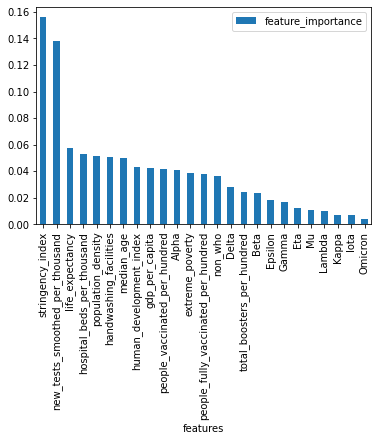

In [ ]:
feature_importance_df.plot(kind='bar')
plt.show()